In [1]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
sc.settings.set_figure_params(dpi=100)

In [2]:
from constants import *
import multiprocessing as mp
from tqdm import tqdm

## DEFINE CONSTANTS
stretch_length_cdr3 = 30
stretch_length_ag = 15

## DEFINE ENCODERS
def _encode_cdr3s(peptide):
    # define columns
    columns = cdr3_alphabet+['charge','hydrophobicity','weight','sulfur','aromatic']
    columns_returned = [f'{idx}{col}' for idx in range(stretch_length_cdr3) for col in columns]
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=range(stretch_length_cdr3), columns=columns)
    step = stretch_length_cdr3 / len(peptide)
    for idx, aa in enumerate(peptide):
        # find start and end of each peptide
        start, end = round(idx * step), round((idx + 1) * step)
        if idx == len(peptide) - 1:
            end = stretch_length_cdr3
        # map to the coordinates
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / stretch_length_cdr3
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        X.loc[start:end, cdr3_alphabet] = 0
        X.loc[start:end, aa] = 1
        X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    return pd.Series(X.values.flatten(), index=columns_returned, name=peptide)
def encode_cdr3s(cdr3s, n_cpus, verbose):
    if verbose: print('\n\tencoding TCRs...', end='')
    # the first step is to create a conversion map for CDR3 sequences
    global cdr3_alphabet
    cdr3_alphabet = sorted(set([el for x in cdr3s for el in list(x)]))
    # work through cdr3s
    els = []
    with mp.Pool(n_cpus) as pool:
        for el in pool.imap_unordered(_encode_cdr3s, cdr3s):
            els.append(el)
    cdr3_to_X = pd.concat(els, axis=1).T
    if verbose: print('done!')
    return cdr3_to_X


def _encode_ags(peptide):
    # define columns
    columns = ag_alphabet+['charge','hydrophobicity','weight','sulfur','aromatic']
    columns_returned = [f'{idx}{col}' for idx in range(stretch_length_ag) for col in columns]
    # create the tracking dataframe
    X = pd.DataFrame(np.nan, index=range(stretch_length_ag), columns=columns)
    step = stretch_length_ag / len(peptide)
    for idx, aa in enumerate(peptide):
        # find start and end of each peptide
        start, end = round(idx * step), round((idx + 1) * step)
        if idx == len(peptide) - 1:
            end = stretch_length_ag
        # map to the coordinates
        charge = amino_acid_charge[aa]
        hydrophobicity = amino_acid_hydrophobicity[aa] / 2
        weight = amino_acid_weights[aa] / stretch_length_ag
        sulfur = 1 * (aa in has_sulfur)
        aromatic = 1 * (aa in is_aromatic)
        X.loc[start:end, ag_alphabet] = 0
        X.loc[start:end, aa] = 1
        X.loc[start:end, ['charge','hydrophobicity','weight','sulfur','aromatic']] = charge, hydrophobicity, weight, sulfur, aromatic
    assert not X.isna().any().any()
    return pd.Series(X.values.flatten(), index=columns_returned, name=peptide)
def encode_ags(ags, n_cpus, verbose):
    if verbose: print('\tencoding antigens...', end='')
    # the first step is to create a conversion map for ag sequences
    global ag_alphabet
    ag_alphabet = sorted(set([el for x in ags for el in list(x)]))
    # work through antigens
    els = []
    with mp.Pool(n_cpus) as pool:
        for el in pool.imap_unordered(_encode_ags, ags):
            els.append(el)
    ag_to_X = pd.concat(els, axis=1).T
    if verbose: print('done!')
    return ag_to_X

In [3]:
# read in the data
a = pd.read_csv('/ssd1/dchen/GNN_PEPTIDE_TCR/data/INCOV.A0201.TCRs.csv', index_col=0)
a = a.dropna(subset=['IR_VDJ_1_junction_aa'])

# retrieve cdr3s and epitopes
cdr3s = a['IR_VDJ_1_junction_aa'].unique()
ags = ['YLQPRTFLL','NLVPMVATV']
print(len(cdr3s), len(ags))

# retrieve the mappings
cdr3_to_X = encode_cdr3s(cdr3s, 40, False)
ag_to_X = encode_cdr3s(ags, 40, False)

24229 2


In [4]:
from tensorflow import keras
# load in the model
model = keras.models.load_model('../outputs/model_v5/model_v5.r1.keras')

2024-01-09 16:03:52.480031: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 16:03:52.662027: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 16:03:53.232574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-09 16:03:53.232669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [5]:
# retrieve YLQ prediction
# prepare inputs
X_cdr3s = cdr3_to_X.loc[a['IR_VDJ_1_junction_aa']]
X_ags = ag_to_X.loc[['YLQPRTFLL']*X_cdr3s.shape[0]].reset_index().iloc[:, 1:]
X_ags.index = X_cdr3s.index

# combine
X_cdr3s.columns = 'cdr3:' + X_cdr3s.columns
X_ags.columns = 'ag:' + X_ags.columns
X = pd.concat([X_cdr3s, X_ags], axis=1)

# read in normalization factors
means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
# subset for relevant columns
X = X.T.reindex(means.index).fillna(0).T
# normalize
X -= means
X /= stds

# retrieve the appropriate columns
cols_cdr3 = X.columns[X.columns.str.startswith('cdr3')]
cols_ag = X.columns[X.columns.str.startswith('ag')]
# predict the binding
pred = model.predict([X[cols_cdr3], X[cols_ag]], workers=40, use_multiprocessing=True)
pred = pd.Series(pred[:, 0], index=a.index).reset_index()
# get the patient timepoint values
pred['pt'] = pred['index'].str.split(':', expand=True).iloc[:, -1].str.slice(0, -2)
pred['pt_incov'] = 'INCOV' + pred['pt'].str.zfill(3)
pred['tp'] = pred['index'].str.slice(-2)
# save
pred['ag'] = 'YLQPRTFLL'
pred_ylq = pred.copy()

1584/1584 [==============================] - 4s 2ms/step


In [6]:
# retrieve NLV prediction
# prepare inputs
X_cdr3s = cdr3_to_X.loc[a['IR_VDJ_1_junction_aa']]
X_ags = ag_to_X.loc[['NLVPMVATV']*X_cdr3s.shape[0]].reset_index().iloc[:, 1:]
X_ags.index = X_cdr3s.index

# combine
X_cdr3s.columns = 'cdr3:' + X_cdr3s.columns
X_ags.columns = 'ag:' + X_ags.columns
X = pd.concat([X_cdr3s, X_ags], axis=1)

# read in normalization factors
means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
# subset for relevant columns
X = X.T.reindex(means.index).fillna(0).T
# normalize
X -= means
X /= stds

# retrieve the appropriate columns
cols_cdr3 = X.columns[X.columns.str.startswith('cdr3')]
cols_ag = X.columns[X.columns.str.startswith('ag')]
# predict the binding
pred = model.predict([X[cols_cdr3], X[cols_ag]], workers=40, use_multiprocessing=True)
pred = pd.Series(pred[:, 0], index=a.index).reset_index()
# get the patient timepoint values
pred['pt'] = pred['index'].str.split(':', expand=True).iloc[:, -1].str.slice(0, -2)
pred['pt_incov'] = 'INCOV' + pred['pt'].str.zfill(3)
pred['tp'] = pred['index'].str.slice(-2)
# save
pred['ag'] = 'NLVPMVATV'
pred_nlv = pred.copy()

1584/1584 [==============================] - 3s 2ms/step


In [7]:
# combine
pred = pd.concat([pred_ylq, pred_nlv], axis=0).reset_index().iloc[:, 1:]

# compute relevant values
on_target = pred.loc[pred['ag'] == 'YLQPRTFLL'].set_index('index')[0]
off_target = pred.loc[pred['ag'] == 'NLVPMVATV'].set_index('index')[0]

# get the patient timepoint values
diff = (on_target - off_target).reset_index()
diff['pt'] = diff['index'].str.split(':', expand=True).iloc[:, -1].str.slice(0, -2)
diff['pt_incov'] = 'INCOV' + diff['pt'].str.zfill(3)
diff['tp'] = diff['index'].str.slice(-2)

# get the patient timepoint values
ratio = (on_target / off_target).reset_index()
ratio['pt'] = ratio['index'].str.split(':', expand=True).iloc[:, -1].str.slice(0, -2)
ratio['pt_incov'] = 'INCOV' + ratio['pt'].str.zfill(3)
ratio['tp'] = ratio['index'].str.slice(-2)

In [8]:
# look at T1
anno = pd.read_table('/home/dchen/Downloads/COVID-19/scRNAseq_analysis/data/clinical_info/observations_2021-11-03_1042.tsv')
anno = anno.loc[anno['incov_redcap_event_name'] == 'baseline_blood_dra_arm_1'].set_index('source_label')['who_ordinal_scale']
anno1 = anno.str.replace('1 or 2','1.5').astype(float).dropna()
# look at T2
anno = pd.read_table('/home/dchen/Downloads/COVID-19/scRNAseq_analysis/data/clinical_info/observations_2021-11-03_1042.tsv')
anno = anno.loc[anno['incov_redcap_event_name'] == 'acute_blood_draw_arm_1'].set_index('source_label')['who_ordinal_scale']
anno2 = anno.str.replace('1 or 2','1.5').astype(float).dropna()
anno = pd.concat([anno1, anno2], axis=1).max(1)
# retrieve colors
palette = sns.color_palette('RdYlGn', 6).as_hex()
color1 = palette[0]
color2 = palette[1]
color3 = palette[5]

/tmp/ipykernel_36445/270088317.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(x='WOS_category', y=0, data=plot, ci=68, errwidth=2, capsize=0.35,
/tmp/ipykernel_36445/270088317.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='WOS_category', y=0, data=plot, ci=68, errwidth=2, capsize=0.35,
/tmp/ipykernel_36445/270088317.py:28: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x='WOS_category', y=0, data=plot, ci=68, errwidth=2, capsize=0.35,
/tmp/ipykernel_36445/270088317.py:28: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(x='WOS_category', y=0, data=plot, ci=68, errwidth

0.06907167139665413
0.8393696328459376
0.13806918285702027
NormaltestResult(statistic=5.5788223152788134, pvalue=0.061457391978135045)
0.04808095990153453
0.6946384327780393
0.026567778456078828
NormaltestResult(statistic=4.084970522037104, pvalue=0.1297059568221493)


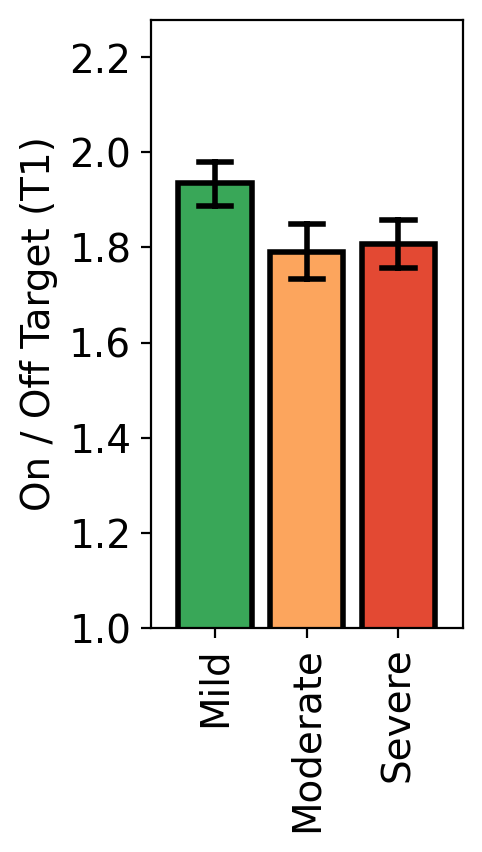

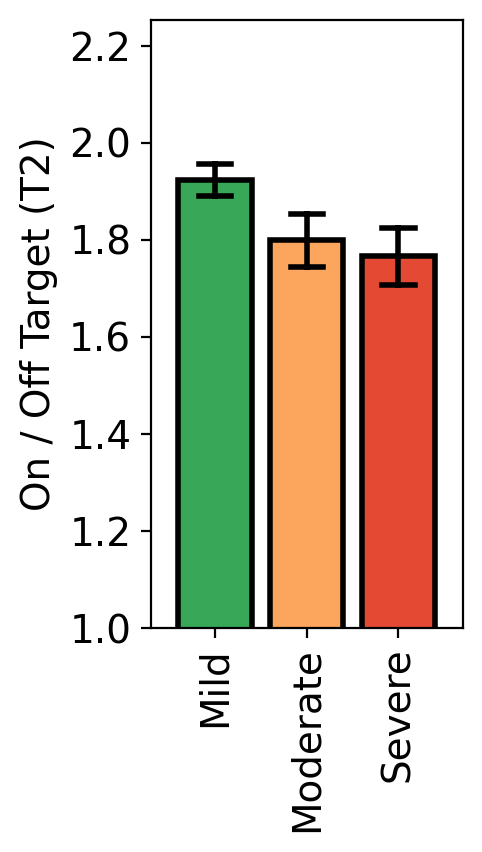

In [9]:
import scipy.stats as ss

# determine cutoff
cutoff = 100

# >>> timepoint 1

# retrieve the data
plot = ratio.loc[ratio['tp'] == '-1', ['pt_incov', 0]].copy()
# filter for good patients that have enough T cells
counts = plot['pt_incov'].value_counts()
valids = counts.index[counts >= cutoff]
plot1 = plot.loc[plot['pt_incov'].isin(valids)]

# get the average
plot = plot1.groupby('pt_incov').mean().mean(1).reset_index()

# add on disease severity
plot['WOS'] = plot['pt_incov'].map(anno).astype(float)
plot['WOS_category'] = 'Moderate'
plot.loc[plot['WOS'] <= 2, 'WOS_category'] = 'Mild'
plot.loc[plot['WOS'] >= 5, 'WOS_category'] = 'Severe'
plot = plot.reset_index()

# setup the barplots
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='WOS_category', y=0, data=plot, ci=68, errwidth=2, capsize=0.35,
            order=['Mild','Moderate','Severe'], palette=[color3, color2, color1],
            saturation=1, edgecolor='k', linewidth=2, errcolor='k')
ax.tick_params(axis='x', labelrotation=90)
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin-0.2, xmax+0.2)
ax.set_xlabel('')
ax.set_ylabel('On / Off Target (T1)')
ymin, ymax = ax.get_ylim()
ax.set_ylim(1, ymax + 0.2)

print(ss.ttest_ind(plot[0][plot['WOS_category'] == 'Mild'],
                   plot[0][plot['WOS_category'] == 'Moderate'])[1])
print(ss.ttest_ind(plot[0][plot['WOS_category'] == 'Severe'],
                   plot[0][plot['WOS_category'] == 'Moderate'])[1])
print(ss.ttest_ind(plot[0][plot['WOS_category'] == 'Mild'],
                   plot[0][plot['WOS_category'] == 'Severe'])[1])
print(ss.normaltest(plot[0]))
# >>> timepoint 2

# retrieve the data
plot = ratio.loc[ratio['tp'] == '-2', ['pt_incov', 0]].copy()
# filter for good patients that have enough T cells
counts = plot['pt_incov'].value_counts()
valids = counts.index[counts >= cutoff]
plot2 = plot.loc[plot['pt_incov'].isin(valids)]

# get the average
plot = plot2.groupby('pt_incov').mean().mean(1).reset_index()

# add on disease severity
plot['WOS'] = plot['pt_incov'].map(anno).astype(float)
plot['WOS_category'] = 'Moderate'
plot.loc[plot['WOS'] <= 2, 'WOS_category'] = 'Mild'
plot.loc[plot['WOS'] >= 5, 'WOS_category'] = 'Severe'
plot = plot.reset_index()

# setup the barplots
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='WOS_category', y=0, data=plot, ci=68, errwidth=2, capsize=0.35,
            order=['Mild','Moderate','Severe'], palette=[color3, color2, color1],
            saturation=1, edgecolor='k', linewidth=2, errcolor='k')
ax.tick_params(axis='x', labelrotation=90)
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin-0.2, xmax+0.2)
ax.set_xlabel('')
ax.set_ylabel('On / Off Target (T2)')
ymin, ymax = ax.get_ylim()
ax.set_ylim(1, ymax + 0.2)

print(ss.ttest_ind(plot[0][plot['WOS_category'] == 'Mild'],
                   plot[0][plot['WOS_category'] == 'Moderate'])[1])
print(ss.ttest_ind(plot[0][plot['WOS_category'] == 'Severe'],
                   plot[0][plot['WOS_category'] == 'Moderate'])[1])
print(ss.ttest_ind(plot[0][plot['WOS_category'] == 'Mild'],
                   plot[0][plot['WOS_category'] == 'Severe'])[1])
print(ss.normaltest(plot[0]))

In [10]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.datasets import get_x_y

def compute_death(clusters):
    # retrieve death data
    # > compute days of death after enrollment
    df_death = pd.read_table('/home/dchen/Downloads/COVID-19/scRNAseq_analysis/data/clinical_info/outcomes_2021-11-03_1042.tsv',index_col=0)
    df_death.index = df_death.index.str.replace('INCOV00','').str.replace('INCOV0','').str.replace('INCOV','')
    assert df_death['death'].unique().tolist() == ['No', 'Yes', 'Unknown', np.nan]
    dead_patients = df_death.index[df_death['death'] == 'Yes'].tolist()
    # > compute days of symptoms before enrollment
    df_info = pd.read_table('/home/dchen/Downloads/COVID-19/scRNAseq_analysis/data/clinical_info/patient_information_2021-11-03_1042.tsv',index_col=0)
    df_info.index = df_info.index.str.replace('INCOV00','').str.replace('INCOV0','').str.replace('INCOV','')
    # > compute days since symptoms till death
    death_days = df_info['onset_of_symptoms_days_before_enrollment'] + df_death['death_days_since_enrollment']
    # combine the data
    clusters['Days till Death or Current Time'] = death_days
    return clusters

def plot_lifelines(clusters, label):
    from lifelines import KaplanMeierFitter
    n_months = 3
    # > set up figure
    fig,ax = plt.subplots(figsize=[4, 4])
    # > plot positive
    positive = clusters.loc[clusters['Group'] == 1].copy().fillna(30.5*n_months+10)
    positive['Died'] = -1 * positive['Days till Death or Current Time'] + 1
    kmf = KaplanMeierFitter(label=f'{label}+', alpha=0.32)
    kmf.fit(positive['Days till Death or Current Time'], positive['Died'])
    kmf.plot(ax=ax, color='tab:red', linewidth=2)
    if sum(clusters['Group'] == 0) > 0:
        # > plot normal
        normal = clusters.loc[clusters['Group'] == 0].copy().fillna(30.5*n_months+10)
        normal['Died'] = -1 * normal['Days till Death or Current Time'] + 1
        kmf = KaplanMeierFitter(label=f'{label}+/-', alpha=0.32)
        kmf.fit(normal['Days till Death or Current Time'], normal['Died'])
        kmf.plot(ax=ax, color='tab:green')
    # > plot negative
    negative = clusters.loc[clusters['Group'] == -1].copy().fillna(30.5*n_months+10)
    negative['Died'] = -1 * negative['Days till Death or Current Time'] + 1
    kmf = KaplanMeierFitter(label=f'{label}-', alpha=0.32)
    kmf.fit(negative['Days till Death or Current Time'], negative['Died'])
    kmf.plot(ax=ax, color='tab:blue', linewidth=2)
    # > decorate figure
    ax.grid(False)
    ax.set(xlabel='Days Since Onset of Symptoms', ylabel='Survival Probability')
    ax.legend(bbox_to_anchor=(1.01,0.99), bbox_transform=ax.transAxes, frameon=False, loc='upper left')
    # > set limits
    ax.set_xlim(0, 30.5*n_months)
    ax.set_ylim(0.5, 1.05)
    
    try:
        survived = clusters.loc[clusters['Days till Death or Current Time'].isna(), 'Group'].value_counts()
        survived.name = 'Survived'
        died = clusters.loc[~clusters['Days till Death or Current Time'].isna(), 'Group'].value_counts()
        died.name = 'Died'
        obs = pd.concat([survived, died], axis=1).fillna(0)
        
        vmax = clusters['Days till Death or Current Time'].dropna().max()
        group_indicator = clusters['Group'].map({-1:'A', 1:'B'})
        groups = group_indicator.unique()
        y = clusters.copy(); y.columns = ['Status','Time']
        y['Status'] = ~y['Time'].isna()
        y['Time'] = y['Time'].astype(float).fillna(vmax)
        y = get_x_y(y, attr_labels=['Status','Time'], pos_label=True, survival=True)[1]
        chi2, pvalue = compare_survival(y, group_indicator)
        print(pvalue)

    except:
        pass

In [11]:
# retrieve the data
plot = ratio.loc[ratio['tp'] == '-2', ['pt_incov', 0]].copy()
# filter for good patients that have enough T cells
counts = plot['pt_incov'].value_counts()
valids = counts.index[counts >= cutoff]
plot2 = plot.loc[plot['pt_incov'].isin(valids)]

# get the average
plot = plot2.groupby('pt_incov').mean().mean(1).reset_index()

# add on disease severity
plot['WOS'] = plot['pt_incov'].map(anno).astype(float)
plot['WOS_category'] = 'Moderate'
plot.loc[plot['WOS'] <= 2, 'WOS_category'] = 'Mild'
plot.loc[plot['WOS'] >= 5, 'WOS_category'] = 'Severe'
plot = plot.reset_index()

In [12]:
# get proteoms
df = pd.read_table('/home/dchen/Downloads/COVID-19/scRNAseq_analysis/write/Proteomic_output/upto_v16/Yapeng_Resubmission_Proteomics_AdjustedImputed_052121.tsv', index_col=1)
df = df.loc[df.index.str.endswith('-AC')]
df.index = df.index.str.replace('-AC','')
df = df.iloc[:, 5:].T
# average out measurements
df['gene'] = df.index.to_series().str.split('_', expand=True).iloc[:, 0]
df = df.groupby('gene').mean().T
# retrieve values
idxs = df.index.intersection(plot['pt_incov'])
df_tmp = df.loc[idxs]
values = plot.set_index('pt_incov').loc[idxs, 0]

In [13]:
# go through genes to determine a plasma proteomic signature
corrs = pd.DataFrame(index=df_tmp.columns, columns=['r','p'])
for col in df_tmp.columns:
    corrs.loc[col] = ss.pearsonr(df_tmp[col], values)

/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fec831101f0>
Traceback (most recent call last):
  File "/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dchen/anac

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fec83110af0>
Traceback (most recent call last):
  File "/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Thread

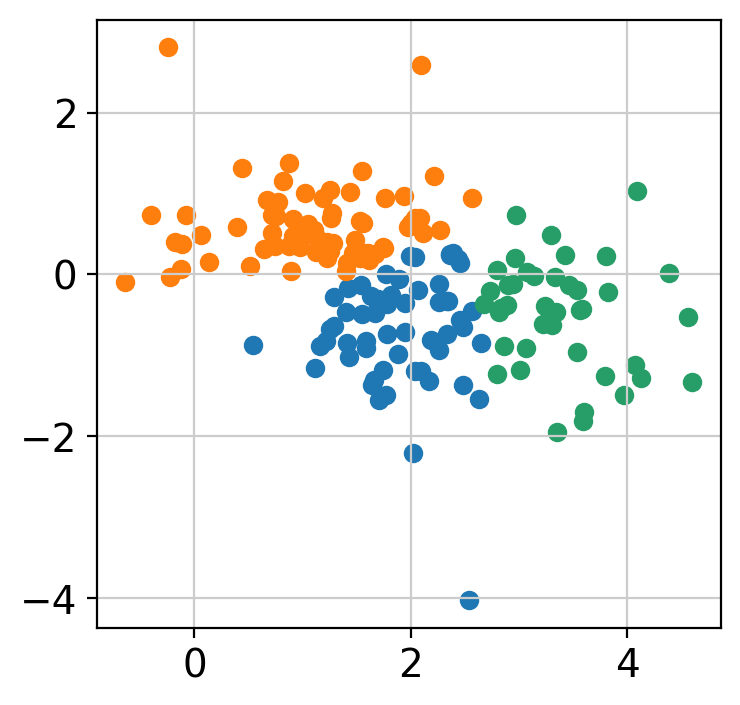

In [14]:
from sklearn.cluster import KMeans
# derive the two gene sets and confirm they are contrary
genes1 = corrs.sort_values('r').index[:10]
genes2 = corrs.sort_values('r').index[-10:]
# derive kmeans clusters
X = pd.concat([df[genes1].mean(1), df[genes2].mean(1)], axis=1)
np.random.seed(0)
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(X)
clusters = kmeans.predict(X)
# now plot it
plt.scatter(df.loc[clusters == 0, genes1].mean(1), df.loc[clusters == 0, genes2].mean(1))
plt.scatter(df.loc[clusters == 1, genes1].mean(1), df.loc[clusters == 1, genes2].mean(1))
plt.scatter(df.loc[clusters == 2, genes1].mean(1), df.loc[clusters == 2, genes2].mean(1))

3.4445122899495364e-06


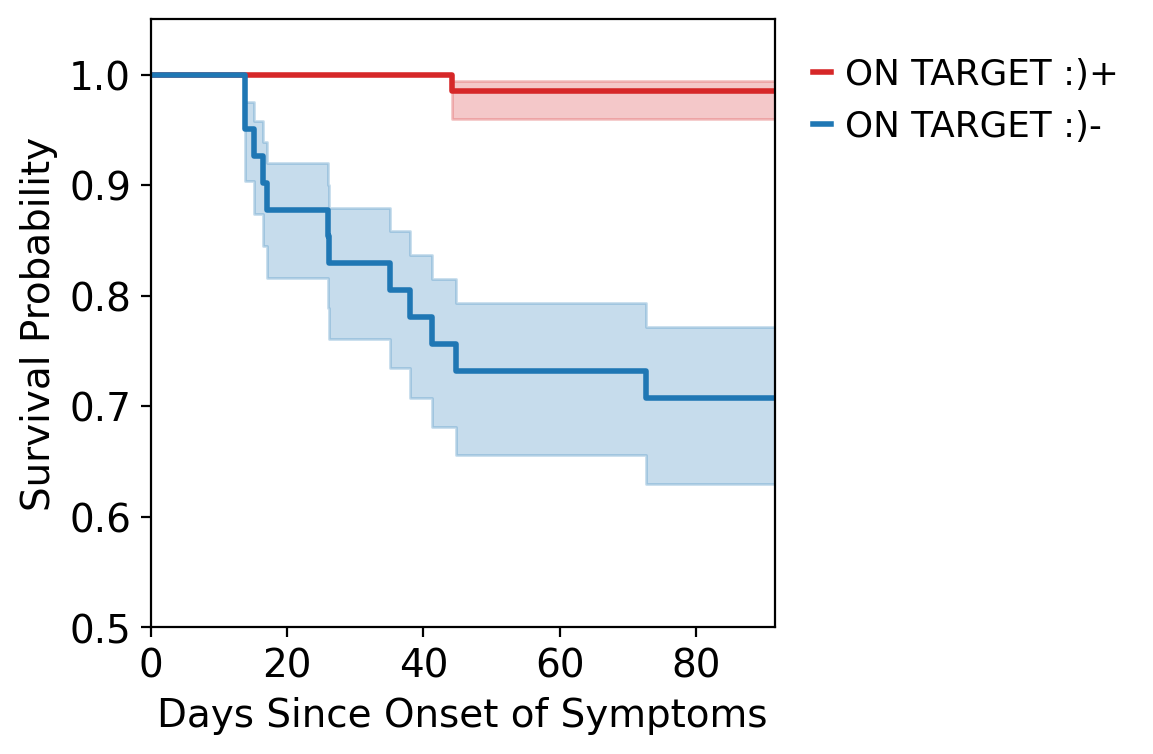

In [15]:
# Kaplan Meier
values = df['IFNG'].copy()
mask_a = values.index.isin(df.index[clusters == 1])
mask_b = values.index.isin(df.index[clusters == 2])
values[:] = np.nan
values[mask_a] = 1
values[mask_b] = -1
clusters = pd.DataFrame(values).dropna()
clusters.index = clusters.index.str.replace('INCOV00','').str.replace('INCOV0','').str.replace('INCOV','')
clusters.columns = ['Group']
clusters = compute_death(clusters)
plot_lifelines(clusters, 'ON TARGET :)')

In [17]:
# get counts
clusters['Group'].value_counts()

Group
 1.0    67
-1.0    41
Name: count, dtype: int64